In this project we first clean the datasets we have using different functions and some of the nltk libraries. 


In [1]:
import re
import string
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

# Removing @Mentions, URL links, Punctuations and numbers
id_remove = lambda x: re.sub(r'@\w+', '', x.lower())
url_remove = lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc = lambda x: x.translate(str.maketrans('', '', string.punctuation))

# Removing stop words and stem the words
def normalize_corpus(corpus,text_stemming=False, stopword_removal=True, text_lemmatize=True, dict_check=True):
    from nltk.tokenize.toktok import ToktokTokenizer
    from nltk.stem import WordNetLemmatizer
    stopwords = nltk.corpus.stopwords.words('english')
    tokenizer = ToktokTokenizer()
    lemmatizer = WordNetLemmatizer()
    words = set(nltk.corpus.words.words())
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove extra newlines
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        
        # stem words
        if text_stemming:
            ps = nltk.stem.snowball.SnowballStemmer('english')
            doc = ' '.join([ps.stem(word) for word in doc.split()])
         
        # lemmatize words
        if text_lemmatize:
            doc=' '.join([lemmatizer.lemmatize(word) for word in doc.split()])

        # check if the words exist in english dictionary
        if dict_check:
            doc=" ".join(w for w in nltk.wordpunct_tokenize(doc) \
                if w.lower() in words or not w.isalpha())
            
        # remove stop words
        if stopword_removal:
            tokens = tokenizer.tokenize(doc)
            tokens = [token.strip() for token in tokens]
            filtered_tokens = [token for token in tokens if token not in stopwords]
            doc = ' '.join(filtered_tokens) 
            
        normalized_corpus.append(doc)
   
    return normalized_corpus

# This function deletes empty documents after cleaning
def delete_zero(df):
    zero=[]
    for i in df.index:
        if len(df.text[i])==0:
            zero.append(i)
    df=df.drop(zero)
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Importing 20 newsgroup dataset and cleaning it:

In [2]:
from sklearn.datasets import fetch_20newsgroups
# Preparing train & test data for 20 news group 
newsgroups_train = fetch_20newsgroups(subset='train', remove = ('headers', 'footers', 'quotes'))
newsgroups_train = pd.DataFrame({'text': newsgroups_train.data, 'target': newsgroups_train.target})
newsgroups_test = fetch_20newsgroups(subset='test', remove = ('headers', 'footers', 'quotes'))
newsgroups_test = pd.DataFrame({'text': newsgroups_test.data, 'target': newsgroups_test.target})

# Removing numbers, upper case letters and punctuations
newsgroups_train['text'] = newsgroups_train.text.map(id_remove).map(url_remove).map(alphanumeric).map(punc)
newsgroups_test['text'] = newsgroups_test.text.map(id_remove).map(url_remove).map(alphanumeric).map(punc)

# Cleaning texts
newsgroups_train['text']=normalize_corpus(newsgroups_train.text)
newsgroups_test['text']=normalize_corpus(newsgroups_test.text)

newsgroups_train=delete_zero(newsgroups_train)
newsgroups_test=delete_zero(newsgroups_test)

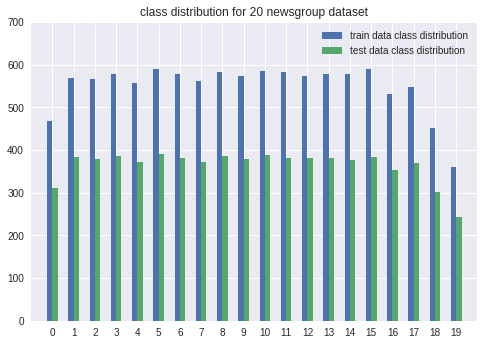

In [211]:
target_count_train=newsgroups_train.target.value_counts().sort_index()
target_count_test=newsgroups_test.target.value_counts().sort_index()

plt.bar(target_count_train.index-0.125, target_count_train, width=0.25, label='train data class distribution')
plt.bar(target_count_test.index +0.125, target_count_test, width=0.25,label='test data class distribution')
plt.title('class distribution for 20 newsgroup dataset')
plt.ylim([0,700])
plt.xlim([-1,20])
plt.xticks(range(0,20))
plt.legend()
plt.show()

Importing Sentiment140 dataset and cleaning it in a form that we can do learning on them

In [16]:
# Preparing train & test data for Sentiment140
sentiment_train = pd.read_csv("training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')
sentiment_train = sentiment_train.drop(columns=['id', 'date', 'query', 'user'])
sentiment_train.polarity = sentiment_train.polarity.replace({0: 0, 4: 1})

sentiment_test = pd.read_csv("new_testdata.manual.2009.06.14.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')
sentiment_test = sentiment_test.drop(columns=['id', 'date', 'query', 'user'])
sentiment_test.polarity = sentiment_test.polarity.replace({0: 0, 4: 1})

# sampling
sentiment_train = sentiment_train.sample(n=50000)

# Cleaning Data
sentiment_train['text'] = sentiment_train['text'].astype('str')
sentiment_test['text'] = sentiment_test['text'].astype('str')
sentiment_train['text'] = sentiment_train.text.map(id_remove).map(url_remove).map(alphanumeric).map(punc)
sentiment_test['text'] = sentiment_test.text.map(id_remove).map(url_remove).map(alphanumeric).map(punc)
sentiment_train['text']=normalize_corpus(sentiment_train.text)
sentiment_test['text']=normalize_corpus(sentiment_test.text)
sentiment_train=delete_zero(sentiment_train)
sentiment_test=delete_zero(sentiment_test)

K-fold cross-validation class consist of two functions. The function cross_validation_split gets the size of data and divide it into k parts and returns a list of indices in the k parts.
The second function, kfoldCV, gets the model, hyper parameter range and whether the parameter which is tuning is a model parametr or not. If the hyperpaarameter is a model parameter, the model can be "Multinomial Naive Bayes" and "Logistic Regression". If not, the cross-validation is done in the parameters of feature extraction.
The return is the best hyper parameter and a list of different hyper parameters and their corresponding accuracy.

In [21]:

class k_fold:
    
    def __init__(self, x, y, k):
        self.x=x
        self.y=y
        self.k=k
        return
    
    def cross_validation_split(self):
        self.list_ind=[]
        N=self.x.shape[0]
        for i in range(self.k-1):
            self.list_ind.append([i*(N//self.k),(i+1)*(N//self.k)]) 
        self.list_ind.append([i*(N//self.k),N])
        return self
    
    def kfoldCV(self , model, hyper_p_range, model_parameters):
        hyper_p_range=list(hyper_p_range)
        acc=np.zeros((len(hyper_p_range),2))
        for i in range(self.k):
            indices=self.list_ind[i]
            x_validation=[]
            y_validation=[]
            x_train=[]
            y_train=[]
            j=0
            # Generating validation set
            x_validation=self.x[indices[0]:indices[1]]
            y_validation=self.y[indices[0]:indices[1]]
            
            # Generating train set
            ind = list(range(indices[0],indices[1]))
            mask = np.ones(self.x.shape[0], dtype=bool)
            mask[ind] = False
            x_train=self.x[mask]
            y_train=self.y[mask]

            # Calculaing accuracy
            for hp in range(len(hyper_p_range)):
                hyper_p=hyper_p_range[hp]
                acc[j][0]=hyper_p
                if model_parameters:
                    if model=='LogisticRegression':
                        model_f=LogisticRegression(penalty='l2', tol=hyper_p, C=0.5, max_iter=400, multi_class='multinomial')
                        y_pred=model_f.fit(x_train,y_train).predict(x_validation)
                    elif model=='MultinomialNB':
                        model_f=MultinomialNaiveBayes(alpha=hyper_p)
                        _,y_pred=model_f.fit(x_train,y_train).predict(x_validation)
                    accu,_,_,_,_ = evaluate_acc(x_validation, y_validation, y_pred)
                else:
                    if model=='CountVectorizer':
                        vectorizer = CountVectorizer(max_df=0.9, min_df=hyper_p)
                        vectors_train = vectorizer.fit_transform(x_train)
                        vectors_test = vectorizer.transform(x_validation)
                        model_f=MultinomialNaiveBayes()
                    elif model=='TfidfVectorizer':
                        vectorizer = TfidfVectorizer(max_df=600, min_df=5)
                        vectors_train = vectorizer.fit_transform(x_train)
                        vectors_test = vectorizer.transform(x_validation)
                        model_f=GaussianNaiveBayes()
                    _,y_pred=model_f.fit(vectors_train,y_train).predict(vectors_test)
                    accu,_,_,_,_ = evaluate_acc(vectors_test, y_validation, y_pred)
                
                acc[j][1]+=accu/self.k                                          # Generating a list of hyperparameter value and corresponding accuracy
                j+=1    
        # choosing best hyperparameter based on maximum accuracy
        max_accuracy=np.where(acc==max(acc[:,1]))
        best_hyper_parametr=float(acc[max_accuracy[0][0]][0])
        return best_hyper_parametr , acc

Calculating hyperparameter "max_df" and "min_df" for CountVectorizer and TfidfVectorizer and then generating train and test sets for 20 newsgroup dataset

In [3]:
count_vector = CountVectorizer(max_df=900 , min_df=5)
count_vect_train = count_vector.fit_transform(newsgroups_train.text)
count_vect_test = count_vector.transform(newsgroups_test.text)

X_train_news_count_vect = count_vect_train
Y_train_news_count_vect = newsgroups_train.target.to_numpy()
X_test_news_count_vect = count_vect_test 
Y_test_news_count_vect = newsgroups_test.target.to_numpy()

vectorizer = TfidfVectorizer(max_df=500 , min_df=90)
vectors_train = vectorizer.fit_transform(newsgroups_train.text)
vectors_test = vectorizer.transform(newsgroups_test.text)

X_train_news_vectorize = vectors_train
Y_train_news_vectorize = newsgroups_train.target.to_numpy()
X_test_news_vectorize = vectors_test 
Y_test_news_vectorize = newsgroups_test.target.to_numpy()



Calculating hyperparameter "max_df" and "min_df" for CountVectorizer and TfidfVectorizer and then generating train and test sets for sentiment140 dataset

In [18]:
count_vector = CountVectorizer(max_df=0.8 , min_df=5)
count_vect_train = count_vector.fit_transform(sentiment_train.text)
count_vect_test = count_vector.transform(sentiment_train.text)

X_train_sent_count_vect = count_vect_train
Y_train_sent_count_vect = sentiment_train.polarity.to_numpy()
X_test_sent_count_vect = count_vect_test 
Y_test_sent_count_vect = sentiment_train.polarity.to_numpy()

vectorizer_sent = TfidfVectorizer(max_df=0.85 , min_df=40)
vectors_train_sent = vectorizer_sent.fit_transform(sentiment_train.text)
vectors_test_sent = vectorizer_sent.transform(sentiment_test.text)

X_train_sent_vectorize = vectors_train_sent
Y_train_sent_vectorize = sentiment_train.polarity.to_numpy()
X_test_sent_vectorize = vectors_test_sent
Y_test_sent_vectorize = sentiment_test.polarity.to_numpy()


The evaluate_acc function gives the test data and predictions as input and returns accuracy, recall, precision, selectivity and negative predictive value.

In [4]:
def evaluate_acc( x_test, y_test, y_pred):
  accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
  TP1=np.where(y_test==1 )
  TP2=np.where(y_pred == y_test)
  TP=np.intersect1d(TP1,TP2)
  FN1=np.where(y_test==1 )
  FN2=np.where(y_pred==0 )
  FN=np.intersect1d(FN1,FN2)
  FP1=np.where(y_test==0 )
  FP2=np.where(y_pred==1 )
  FP=np.intersect1d(FP1,FP2)
  TN1=np.where(y_test==0 )
  TN2=np.where(y_pred==0 )
  TN=np.intersect1d(TN1,TN2)
  recall = TP.shape[0]/(FN.shape[0]+TP.shape[0]+0.001)
  precision=TP.shape[0]/(FP.shape[0]+TP.shape[0]+0.001)
  Selectivity=TN.shape[0]/(TN.shape[0]+FP.shape[0]+0.001)
  N_predictive_v=TN.shape[0]/(TN.shape[0]+FN.shape[0]+0.001)
  return accuracy,recall,precision,Selectivity,N_predictive_v

The Gaussian Naive Bayes is implemented here as a class. We use Gaussian Naive Bayes to classify data generated by tf-idf, since they 

In [5]:
class GaussianNaiveBayes:
    
    def __init__(self):
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        mu,mu2, sigma = np.zeros((C,D)), np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C) 
        for c in range(C):
            x_c = x[y == c]                           
            Nc[c] = x_c.shape[0]                      
            x_c_squared = x_c.copy()
            x_c_squared.data **= 2
            for ic in range(D):               
                mu[c,ic] = (x_c[:,ic].sum()+1) / (Nc[c]+C)
                mu2[c,ic]=((x_c_squared[:,ic]).sum()+1) / (Nc[c]+C)
                sigma[c,ic]=np.sqrt(mu2[c,ic]-mu[c,ic]**2)
        self.mu = mu                                  
        self.sigma = sigma                         
        self.pi =(Nc+1)/(N+C)
        return self


def logsumexp(Z):                                                
    Zmax = np.max(Z,axis=0)[None,:]                              
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt):
    Nt, D = xt.shape
    log_prior = np.log(self.pi)[:, None] 
    C,Dt=self.mu.shape
    log_likelihood=np.zeros((C,Nt))
    for i in range(Nt):
          xt_i=xt.tocsr()[i,:].todense()
          for j in range(C):
              log_liklihood_i=-.5 * np.log(2*np.pi) - np.log(self.sigma[j,:]) -.5 * (np.power((xt_i - self.mu[j,:])/self.sigma[j,:],2))
              log_likelihood[j,i] = np.sum(log_liklihood_i)
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    y_pred = np.argmax(posterior.T, 1)
    return posterior.T,y_pred
    
GaussianNaiveBayes.predict = predict

In [6]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=1):
        self.alpha=alpha
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        self.theta = np.zeros((C,D))
        self.prior = np.zeros(C)
        for c in range(C):
            x_c = x[y == c]
            self.theta[c,:] = (np.sum(x_c, 0) + self.alpha) / (np.sum(x_c) + self.alpha * D)
            self.prior[c] = x_c.shape[0] / len(y)
        return self
    
    def predict(self, x_test): 
        N = x_test.shape[0]
        log_prior = np.log(self.prior)[:, None]
        C,Dt=self.theta.shape
        log_likelihood=np.zeros((C,N))
        log_theta=np.log(self.theta)
        for i in range(N):
             xti=x_test.tocsr()[i,:].todense()
             for j in range(C):
                 log_likelihood[j,i] = np.dot(xti,log_theta[j,:])
        log_posterior = log_prior + log_likelihood
        posterior = log_posterior
        y_pred = np.argmax(posterior.T, 1)
        return posterior.T, y_pred 

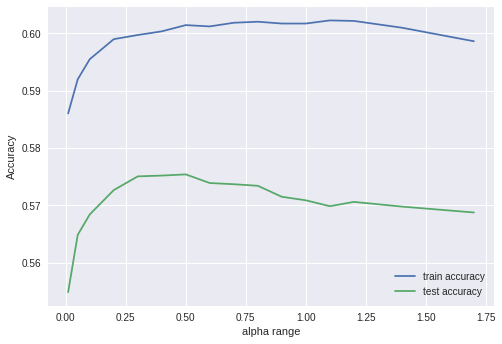

In [168]:
model_cv=k_fold(X_train_news_vectorize,Y_train_news_vectorize, k=5) 
alpha_news, accuracies_list_news_train =model_cv.cross_validation_split().kfoldCV(model='MultinomialNB', hyper_p_range=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.4,1.7], model_parameters=True)
model_cv=k_fold(X_test_news_vectorize,Y_test_news_vectorize, k=5) 
alpha_news, accuracies_list_news_test =model_cv.cross_validation_split().kfoldCV(model='MultinomialNB', hyper_p_range=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.4,1.7], model_parameters=True)

plt.plot(accuracies_list_news_train[:,0],accuracies_list_news_train[:,1],label='train accuracy')
plt.plot(accuracies_list_news_test[:,0],accuracies_list_news_test[:,1],label='test accuracy')
plt.xlabel("alpha range")
plt.ylabel("Accuracy")
plt.legend()

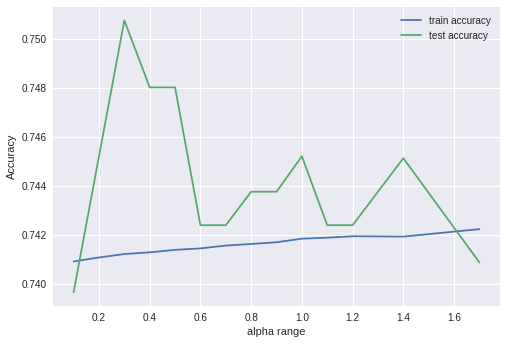

In [225]:
model_cv=k_fold(X_train_sent_vectorize,Y_train_sent_vectorize, k=5) 
alpha_sent, accuracies_list_sent_train =model_cv.cross_validation_split().kfoldCV(model='MultinomialNB', hyper_p_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.4,1.7], model_parameters=True)
model_cv=k_fold(X_test_sent_vectorize,Y_test_sent_vectorize, k=5) 
alpha_sent, accuracies_list_sent_test =model_cv.cross_validation_split().kfoldCV(model='MultinomialNB', hyper_p_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.4,1.7], model_parameters=True)

plt.plot(accuracies_list_sent_train[:,0],accuracies_list_sent_train[:,1],label='train accuracy')
plt.plot(accuracies_list_sent_test[:,0],accuracies_list_sent_test[:,1],label='test accuracy')
plt.xlabel("alpha range")
plt.ylabel("Accuracy")
plt.legend()

In [170]:
# applying Naive Bayes on 20 Newsgroup
model = GaussianNaiveBayes()
model.fit(X_train_news_vectorize, Y_train_news_vectorize)
y_prob_news_GNB, y_pred_news_GNB = model.predict(X_test_news_vectorize)
accuracy_GNB,_,_,_,_=evaluate_acc(X_test_news_vectorize,Y_test_news_vectorize, y_pred_news_GNB)
print(f'20 newsgroup accuracy with Gaussian Naive Bayes: {accuracy_GNB}')

model = MultinomialNaiveBayes(alpha=0.25)
model.fit(X_train_news_count_vect, Y_train_news_count_vect)
y_prob_news_MNB, y_pred_news_MNB = model.predict(X_test_news_count_vect)
accuracy_MNB,_,_,_,_=evaluate_acc(X_test_news_count_vect,Y_test_news_count_vect, y_pred_news_MNB)
print(f'20 newsgroup accuracy with Multinomial Naive Bayes: {accuracy_MNB}')

20 newsgroup accuracy with Gaussian Naive Bayes: 0.4462402410628681
20 newsgroup accuracy with Multinomial Naive Bayes: 0.6716888097520888


In [227]:
# applying Naive Bayes on Sentiment140
model = GaussianNaiveBayes()
model.fit(X_train_sent_vectorize, Y_train_sent_vectorize)
y_prob_sent_GNB, y_pred_sent_GNB = model.predict(X_test_sent_vectorize)
accuracy_GNB,_,_,_,_=evaluate_acc(X_test_sent_vectorize,Y_test_sent_vectorize, y_pred_sent_GNB)
print(f'sentiment140 accuracy with Gaussian Naive Bayes: {accuracy_GNB}')

model = MultinomialNaiveBayes()
model.fit(X_train_sent_count_vect, Y_train_sent_count_vect)
y_prob_sent_MNB, y_pred_sent_MNB = model.predict(X_test_sent_count_vect)
accuracy_MNB,_,_,_,_=evaluate_acc(X_test_sent_count_vect,Y_test_sent_count_vect, y_pred_sent_MNB)
print(f'sentiment140 accuracy with Multinomial Naive Bayes: {accuracy_MNB}')

sentiment140 accuracy with Gaussian Naive Bayes: 0.7771587743732591
sentiment140 accuracy with Multinomial Naive Bayes: 0.7839803143674986


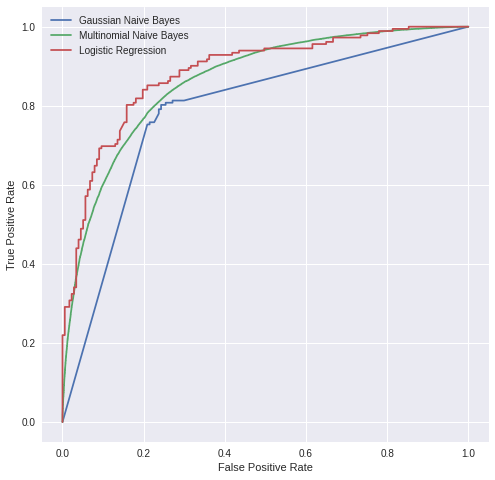

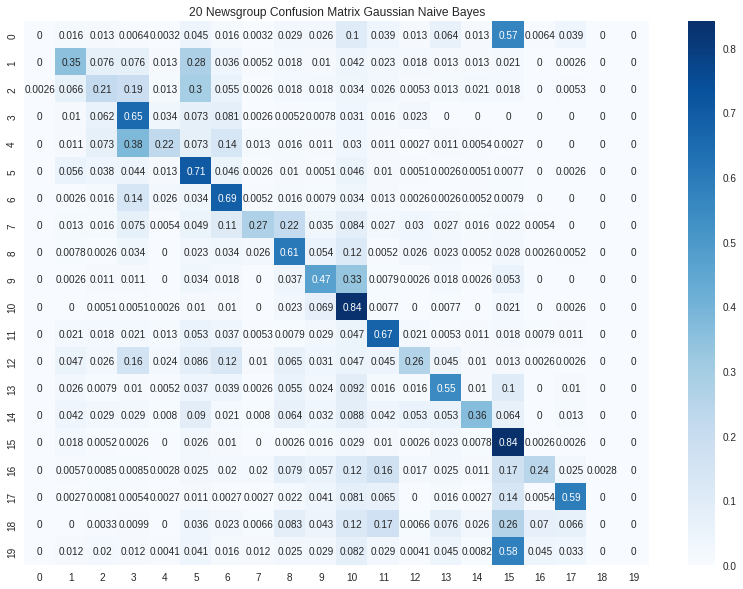

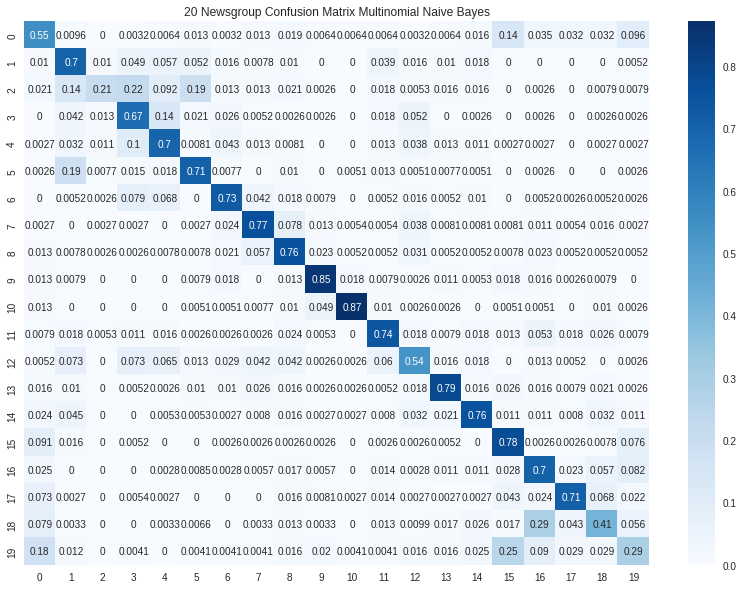

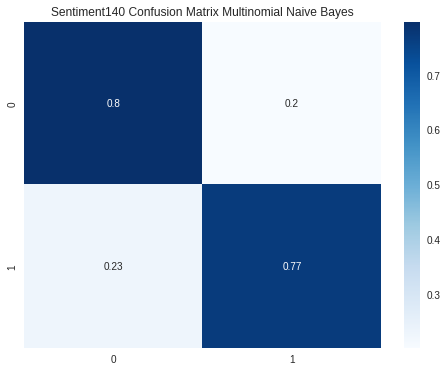

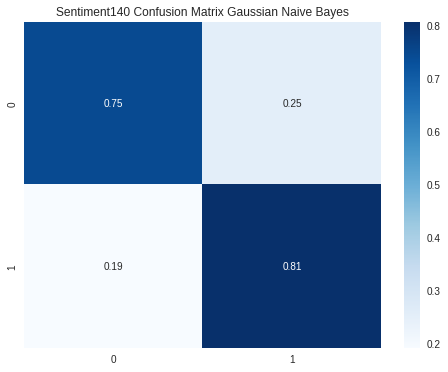

In [233]:
from sklearn.metrics import roc_curve
plt.style.use('seaborn')
def draw_roc(y_test, y_prob,l):
    N , C = y_prob.shape
    y_prob_act=np.zeros((N,C))
    for i in range(N):
        for j in range(C):
            y_prob_act[i,j]=np.exp(y_prob[i,j])/np.sum(np.exp(y_prob[i,:]))
    fpr_dt_1, tpr_dt_1,_=roc_curve(y_test,y_prob_act[:,1])
    plt.plot(fpr_dt_1,tpr_dt_1,label=l)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.gcf().set_size_inches(8, 8)
    return 

draw_roc(Y_test_sent_vectorize,y_prob_sent_GNB,l='Gaussian Naive Bayes')
draw_roc(Y_test_sent_count_vect,y_prob_sent_MNB,l='Multinomial Naive Bayes')
draw_roc(Y_test_sent_vectorize,y_prob_LR_sent,l='Logistic Regression')
plt.show()

#draw_roc(Y_test_news_vectorize[],y_prob_news_GNB,)
from sklearn.metrics import confusion_matrix
import seaborn as sns
def draw_cf_matrix(y_test,y_pred,width,height,title):
  cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
  ax.set_title(title);
  plt.gcf().set_size_inches(width, height)
  plt.show()


draw_cf_matrix(Y_test_news_vectorize,y_pred_news_GNB, 14,10, '20 Newsgroup Confusion Matrix Gaussian Naive Bayes')
draw_cf_matrix(Y_test_news_count_vect,y_pred_news_MNB, 14,10,  '20 Newsgroup Confusion Matrix Multinomial Naive Bayes')
draw_cf_matrix(Y_test_sent_count_vect,y_pred_sent_MNB, 8,6, 'Sentiment140 Confusion Matrix Multinomial Naive Bayes')
draw_cf_matrix(Y_test_sent_vectorize,y_pred_sent_GNB, 8,6, 'Sentiment140 Confusion Matrix Gaussian Naive Bayes')

Here we plot ROC curve for 20newsgroup dataset. It is drawn by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

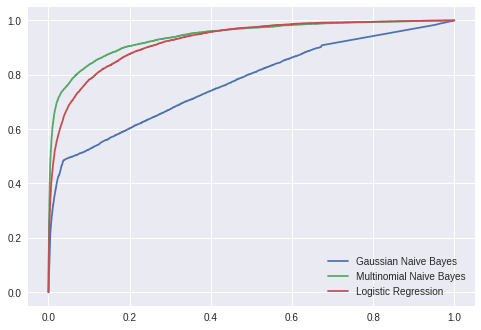

In [253]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
def draw_roc(y_test, y_prob,l):
    fpr = dict()
    tpr = dict()
    y = label_binarize(y_test, classes=list(range(0,20)))
    n_classes=np.max(y_test)+1
    N , C = y_prob.shape
    y_prob_act=np.zeros((N,C))
    for i in range(N):
        a=np.max(y_prob[i,:])
        y_prob[i,:]=y_prob[i,:]-a
        for j in range(C):
            y_prob_act[i,j]=np.exp(y_prob[i,j])/np.sum(np.exp(y_prob[i,:]))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_prob_act[:, i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_prob_act.ravel())
    plt.plot(fpr["micro"], tpr["micro"],label=l)
    plt.legend()
    return

draw_roc(Y_test_news_vectorize,y_prob_news_GNB,l='Gaussian Naive Bayes')
draw_roc(Y_test_news_count_vect,y_prob_news_MNB,l='Multinomial Naive Bayes')
draw_roc(Y_test_news_vectorize,y_prob_LR_news,l='Logistic Regression')


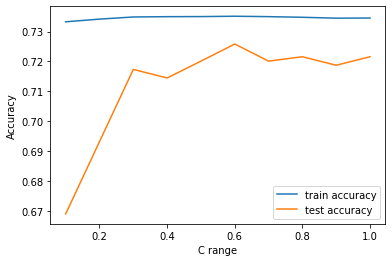

In [19]:
model_cv=k_fold(X_train_sent_vectorize,Y_train_sent_vectorize ,k=5) 
C_news, accuracies_list_sent_train =model_cv.cross_validation_split().kfoldCV(model='LogisticRegression', hyper_p_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],model_parameters=True)
model_cv=k_fold(X_test_sent_vectorize,Y_test_sent_vectorize ,k=5) 
C_sent, accuracies_list_sent_test =model_cv.cross_validation_split().kfoldCV(model='LogisticRegression', hyper_p_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],model_parameters=True)

plt.plot(accuracies_list_sent_train[:,0],accuracies_list_sent_train[:,1],label='train accuracy')
plt.plot(accuracies_list_sent_test[:,0],accuracies_list_sent_test[:,1],label='test accuracy')
plt.xlabel("C range")
plt.ylabel("Accuracy")
plt.legend()

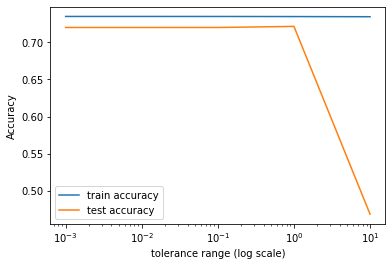

In [24]:
model_cv=k_fold(X_train_sent_vectorize,Y_train_sent_vectorize ,k=5) 
tol_sent, accuracies_list_sent_train =model_cv.cross_validation_split().kfoldCV(model='LogisticRegression', hyper_p_range=[0.001,0.01,0.1,1,10],model_parameters=True)
model_cv=k_fold(X_test_sent_vectorize,Y_test_sent_vectorize ,k=5) 
tol_sent_test, accuracies_list_sent_test =model_cv.cross_validation_split().kfoldCV(model='LogisticRegression', hyper_p_range=[0.001,0.01,0.1,1,10],model_parameters=True)

plt.plot(accuracies_list_sent_train[:,0],accuracies_list_sent_train[:,1],label='train accuracy')
plt.plot(accuracies_list_sent_test[:,0],accuracies_list_sent_test[:,1],label='test accuracy')
plt.xscale("log")
plt.xlabel("tolerance range (log scale)")
plt.ylabel("Accuracy")
plt.legend()

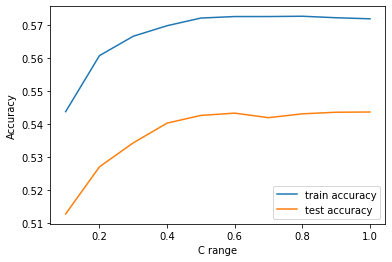

In [15]:
model_cv=k_fold(X_train_news_vectorize,Y_train_news_vectorize ,k=5) 
C_news, accuracies_list_news_train =model_cv.cross_validation_split().kfoldCV(model='LogisticRegression', hyper_p_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],model_parameters=True)
model_cv=k_fold(X_test_news_vectorize,Y_test_news_vectorize ,k=5) 
C_news_test, accuracies_list_news_test =model_cv.cross_validation_split().kfoldCV(model='LogisticRegression', hyper_p_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],model_parameters=True)

plt.plot(accuracies_list_news_train[:,0],accuracies_list_news_train[:,1],label='train accuracy')
plt.plot(accuracies_list_news_test[:,0],accuracies_list_news_test[:,1],label='test accuracy')
plt.xlabel("C range")
plt.ylabel("Accuracy")
plt.legend()

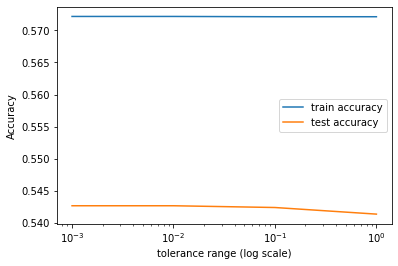

In [25]:
model_cv=k_fold(X_train_news_vectorize,Y_train_news_vectorize ,k=5) 
tol_news, accuracies_list_news_train =model_cv.cross_validation_split().kfoldCV(model='LogisticRegression', hyper_p_range=[0.001,0.01,0.1,1],model_parameters=True)
model_cv=k_fold(X_test_news_vectorize,Y_test_news_vectorize ,k=5) 
tol_news_test, accuracies_list_news_test =model_cv.cross_validation_split().kfoldCV(model='LogisticRegression', hyper_p_range=[0.001,0.01,0.1,1],model_parameters=True)

plt.plot(accuracies_list_news_train[:,0],accuracies_list_news_train[:,1],label='train accuracy')
plt.plot(accuracies_list_news_test[:,0],accuracies_list_news_test[:,1],label='test accuracy')
plt.xscale("log")
plt.xlabel("tolerance range (log scale)")
plt.ylabel("Accuracy")
plt.legend()

In [27]:
from sklearn.linear_model import LogisticRegression
def lr_score(X_train, Y_train, X_test, Y_test, tolerance, C_LR, max_iterations, pen):
  model = LogisticRegression(penalty=pen,tol=tolerance, C=C_LR , max_iter=max_iterations, multi_class='multinomial')

  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)
  Y_prob = model.predict_proba(X_test)
  acc=evaluate_acc(X_test, Y_test, Y_pred)[0]
  return acc , Y_prob


acc_LR_news, y_prob_LR_news=lr_score(X_train_news_vectorize, Y_train_news_vectorize, X_test_news_vectorize, Y_test_news_vectorize, tol_news, C_news, 400, 'l2')
acc_LR_sent, y_prob_LR_sent=lr_score(X_train_sent_vectorize, Y_train_sent_vectorize, X_test_sent_vectorize, Y_test_sent_vectorize, tol_sent, C_sent, 400, 'l2')

print(f'sentiment140 accuracy with Logistic Regression: {acc_LR_news}')
print(f'sentiment140 accuracy with Gaussian Naive Bayes: {acc_LR_sent}')

sentiment140 accuracy with Logistic Regression: 0.5244505494505495
sentiment140 accuracy with Gaussian Naive Bayes: 0.7627118644067796


In [28]:
from sklearn.neural_network import MLPClassifier

# create MLP classifier model, train and return accuracy on test set
# layers allows for hyperparameter tuning
def mlp_score(X_train, Y_train, X_test, Y_test, layers):
  model = MLPClassifier(layers, max_iter=500)
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)
  return(evaluate_acc(X_test, Y_test, Y_pred)[0])

print(mlp_score(X_train_news_vectorize, Y_train_news_vectorize, X_test_news_vectorize, Y_test_news_vectorize, (200,)))
print(mlp_score(X_train_sent_vectorize, Y_train_sent_vectorize, X_test_sent_vectorize, Y_test_sent_vectorize, (200,)))

0.4489010989010989
0.7175141242937854
